In [1]:
%cd ..

f:\minowa\BloodPressureEstimation\repos\latent-diffusion


In [2]:


from tqdm import trange
import torch
from omegaconf import OmegaConf
import numpy as np
from ldm.util import instantiate_from_config
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os


In [9]:
import ipympl

ModuleNotFoundError: No module named 'ipympl'

In [3]:
#@title loading utils



def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    # config = OmegaConf.load("models/first_stage_models/v4_ppg2abp-kl-f4/ppg.yaml")  
    # model = load_model_from_config(config, "models/first_stage_models/v4_ppg2abp-kl-f4/ppg.ckpt")
    config = OmegaConf.load("models/first_stage_models/v4_ppg2abp-kl-f4/abp.yaml")  
    model = load_model_from_config(config, "models/first_stage_models/v4_ppg2abp-kl-f4/abp.ckpt")
    return model

In [4]:
model = get_model()

Loading model from models/first_stage_models/v4_ppg2abp-kl-f4/abp.ckpt


C:\Users\bsa\AppData\Local\Temp\ipykernel_10680\1079318291.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt)#, map_location="cpu")


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64) = 192 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [5]:
from torch.utils.data import Dataset
def make_dataset(dir):
    print(os.path.isfile(dir))
    if os.path.isfile(dir):
        arr = np.genfromtxt(dir, dtype=str, encoding='utf-8')
        if arr.ndim:
            images = [i for i in arr]
        else:
            images = np.array([arr])
    else:
        images = []
        assert os.path.isdir(dir), '%s is not a valid directory' % dir
        for root, _, fnames in sorted(os.walk(dir)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    images.append(path)

    return images
class PPG2ABPDataset_v3_base(Dataset):
    def __init__(self,data_flist,data_root = r"..\..\data\processed\BP_npy\0625_256_2_clean\p00",
                 data_len=1000, size=224, loader=None):
        self.data_root = data_root
        self.data_flist = data_flist
        self.flist = make_dataset(self.data_flist)
        # self.tfs = transforms.ToTensor()
        self.size = size
        self.data=self.load_npys()
        if data_len > 0:
            data_index = np.arange(0,len(self.data),max(len(self.data)//int(data_len),1)).astype(int)[:int(data_len)]
            self.data = self.data[data_index]
        else:
            self.data = self.data[:len(self.data)-len(self.data)%64]
        print("data prepared:" ,self.data.shape)
    def load_npys(self):
        data = []
        for f in self.flist:
            arr = np.load(self.data_root+"\\"+str(f))
            if len(arr) != 0:
                data.append(arr)
        data = np.concatenate(data)
        self.sbp = np.max(data[:,:,0],axis=-1)
        
        return data
    
    def __getitem__(self, index):
        ret = {}
        ret['gt_image'] = self.data[index,:,0].reshape(1,-1).astype(np.float32)
        ret['cond_image'] = self.data[index,:,1].reshape(1,-1).astype(np.float32)
        ret['path'] = str(index)
        return ret

    def __len__(self):
        return self.data.shape[0]
class PPG2ABPDataset_v3_Train(PPG2ABPDataset_v3_base):
    def __init__(self, data_len=-1, size=224, loader=None):
        super().__init__(data_len=data_len,data_flist = r"..\..\data\processed\list\train_BP2.txt")

In [6]:
import ldm.data.ppg2abp as ppg2abp
dataset = PPG2ABPDataset_v3_Train()
# dataset = ppg2abp.PPG2ABPDataset_v3_Test(data_len=10000)
n_samples = len(dataset)
batch_size=32
train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=False)

True
data prepared: (103232, 256, 2)


In [7]:
dataset.sbp[:dataset.data[:,:,0].shape[0]].shape,dataset.data[:,:,0].shape

((103232,), (103232, 256))

In [8]:
import pandas as pd
df = pd.DataFrame({
    "data":dataset.data[:,:,0],
    "sbp":dataset.sbp[:dataset.data[:,:,0].shape[0]]})

Exception: Data must be 1-dimensional

In [9]:
df = pd.DataFrame(columns=["data","sbp"])
for i in trange(len(dataset)):
    tmp = {"data":[],"sbp":[]}
    tmp["data"].append(dataset.data[i,:,0])
    tmp["sbp"] = dataset.sbp[i]
    a = pd.DataFrame(tmp)
    df = pd.concat([df,a])


100%|██████████| 103232/103232 [01:42<00:00, 1011.84it/s]


In [10]:
df = df.drop(columns=["level_0","index"])

KeyError: "['level_0' 'index'] not found in axis"

In [11]:
df = df.reset_index(drop=True)
df.head()

,data,sbp
0,"[0.17600273465355687, 0.18088957974913344, 0.2...",0.681227
1,"[0.187655980650701, 0.18840780297309734, 0.190...",0.684611
2,"[0.19968513780904318, 0.19968513780904318, 0.2...",0.677092
3,"[0.17825820162074602, 0.18126549091033162, 0.2...",0.644012
4,"[0.16698086678480017, 0.16773268910719663, 0.1...",0.634614


In [12]:
df['target_bin'] = pd.cut(df['sbp'], bins=[0.2692287 , 0.34230583, 0.41538296, 0.48846009, 0.56153722,
        0.63461435, 0.70769148, 0.78076861, 0.85384574, 0.92692287,
        1.        ], labels=False)

In [13]:
print(df['target_bin'].value_counts())
df.head()

3    20237
4    16921
2    16879
5    12607
1     9264
6     8703
7     7031
8     5152
0     3389
9     3049
Name: target_bin, dtype: int64


,data,sbp,target_bin
0,"[0.17600273465355687, 0.18088957974913344, 0.2...",0.681227,5
1,"[0.187655980650701, 0.18840780297309734, 0.190...",0.684611,5
2,"[0.19968513780904318, 0.19968513780904318, 0.2...",0.677092,5
3,"[0.17825820162074602, 0.18126549091033162, 0.2...",0.644012,5
4,"[0.16698086678480017, 0.16773268910719663, 0.1...",0.634614,5


In [14]:
df['target_bin'].value_counts().min()

3049

In [15]:
from sklearn.utils import resample
balanced_df = pd.concat([
    resample(df[df['target_bin'] == b], replace=False, n_samples=500, random_state=42)
    # resample(df[df['target_bin'] == b], replace=False, n_samples=df['target_bin'].value_counts().min(), random_state=42)
    for b in df['target_bin'].dropna().unique()
])

In [16]:
print(balanced_df['target_bin'].value_counts())
balanced_df.head()

7    500
3    500
6    500
2    500
9    500
5    500
1    500
8    500
4    500
0    500
Name: target_bin, dtype: int64


,data,sbp,target_bin
68380,"[0.1091642812900635, 0.1091642812900635, 0.111...",0.648069,5
7890,"[0.08879134525557564, 0.09029498990036844, 0.0...",0.640629,5
41770,"[0.1369079738889446, 0.13878752969493557, 0.14...",0.642508,5
56789,"[0.12036788279622401, 0.12675837253659328, 0.1...",0.676716,5
32076,"[0.08270021309853293, 0.0845045813843191, 0.09...",0.673932,5


In [17]:
balanced_df = balanced_df.reset_index(drop=True)
balanced_df.head()

,data,sbp,target_bin
0,"[0.1091642812900635, 0.1091642812900635, 0.111...",0.648069,5
1,"[0.08879134525557564, 0.09029498990036844, 0.0...",0.640629,5
2,"[0.1369079738889446, 0.13878752969493557, 0.14...",0.642508,5
3,"[0.12036788279622401, 0.12675837253659328, 0.1...",0.676716,5
4,"[0.08270021309853293, 0.0845045813843191, 0.09...",0.673932,5


In [18]:
balanced_data = np.stack(balanced_df["data"].values)
balanced_data = np.stack([balanced_data,balanced_data],axis=-1)

In [19]:
balanced_data.shape

(5000, 256, 2)

In [20]:
dataset.data = balanced_data

In [21]:
sbp = np.max(balanced_data[:,:,0],axis=-1)
sbp2 = np.max(dataset.data[:,:,0],axis=-1)

(array([501., 500., 501., 501., 501., 497., 504., 495., 500., 500.]),
 array([0.26979199, 0.34280526, 0.41581853, 0.48883179, 0.56184506,
        0.63485833, 0.70787159, 0.78088486, 0.85389812, 0.92691139,
        0.99992466]),
 <a list of 10 Patch objects>)

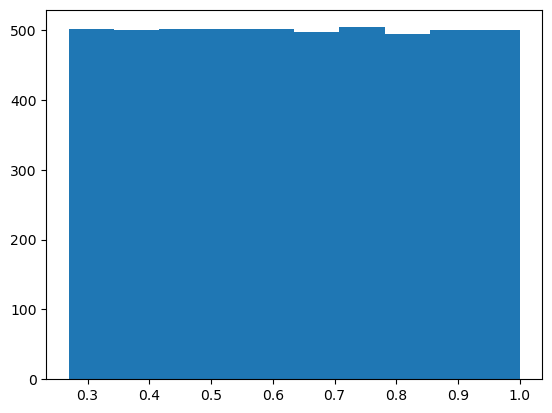

In [22]:
plt.hist(sbp)

(array([501., 500., 501., 501., 501., 497., 504., 495., 500., 500.]),
 array([0.26979199, 0.34280526, 0.41581853, 0.48883179, 0.56184506,
        0.63485833, 0.70787159, 0.78088486, 0.85389812, 0.92691139,
        0.99992466]),
 <a list of 10 Patch objects>)

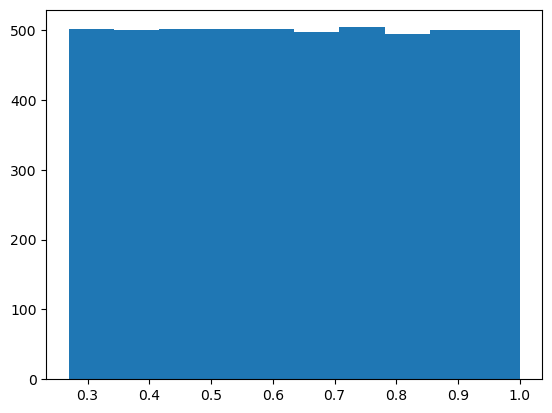

In [23]:
plt.hist(sbp2)

In [24]:
from sklearn.manifold import TSNE

In [25]:
len(dataset),batch_size

(5000, 32)

In [32]:
from tqdm import tqdm
all_images = []
all_gt_images = []
all_recon_images= []
n_samples = len(dataset)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=False)
print(f"Running conditional sampling for {n_samples} samples")
for data in tqdm(train_loader):
    # data = next(iter(train_loader))
    input = data['gt_image'].to("cuda")
    # vae 
    a = model.encode(input)
    # a.parameters.requires_grad_(True)  # Aを勾配計算可能にする
    z = a.sample()
    # A = a.parameters
    recon,_ = model(input)
    # dim = z.size(1)

    # # 勾配計算
    # grads = []
    # for i in range(dim):
    #     grad = torch.autograd.grad(outputs=z[:, i], inputs=A, grad_outputs=torch.ones_like(z[:, i]), retain_graph=True, create_graph=True)[0]
    #     grads.append(grad)

    # grads = torch.stack(grads, dim=0)
    # # print(grads.shape)
    # # チャネル平均
    # alpha = grads.mean(dim=(1, 3))
    # # print(alpha.shape,A.shape,z.shape)# 1, 3, 4は対応する次元で平均をとる
    # M_i = torch.einsum('ij,kjl->ijl', alpha, A)

    # # ReLU適用
    # M_i = F.relu(M_i)

    # # 潜在空間次元ごとに平均
    # M = M_i.mean(dim=0)
    # A.requires_grad_(False)
    # print(z.shape,M.shape)
    all_images.append(z.detach().clone().cpu().numpy())
    all_recon_images.append(recon.detach().clone().cpu().numpy())
    all_gt_images.append(data['gt_image'])
    # n_saved = save_logs(logs,data['gt_image'], logdir, n_saved=n_saved, key="sample",np_path=nplog)
    # if n_saved >= n_samples:
    #     print(f'Finish after generating {n_saved} samples')
    #     break
all_img = np.concatenate(all_images,axis=0)
# all_img = all_img[:n_samples]
all_gt_img = np.concatenate(all_gt_images, axis=0)
all_recon_img = np.concatenate(all_recon_images, axis=0)
# all_gt_img = all_gt_img[:n_samples]

  0%|          | 0/157 [00:00<?, ?it/s]

Running conditional sampling for 5000 samples


100%|██████████| 157/157 [00:02<00:00, 60.38it/s]


In [49]:
all_img = all_img.reshape(-1,192)
all_img.shape

(5000, 192)

In [36]:
all_gt_img = all_gt_img[:,0,:]
all_recon_img = all_recon_img[:,0,:]
all_gt_img.shape,all_recon_img.shape


((5000, 256), (5000, 256))

In [30]:
print(all_gt_img.shape)
sbp = np.max(all_gt_img,axis=1)
sbp.shape

(5000, 256)


(5000,)

In [39]:
scales = np.load(r"../../data\processed\BP_npy\0625_256_2_clean\p00\scale_train.npy")
def calc_min_max(x):
    # x = (x.astype(np.float32)/127.5-1)
    return np.nanmin(x,axis=1),np.nanmax(x,axis=1)
gt_min,gt_max = calc_min_max(all_gt_img)
out_min,out_max = calc_min_max(all_recon_img)

In [40]:
gt_min[:] -= scales[0,0]
gt_min[:] /= scales[0,1]
gt_max[:] -= scales[0,0]
gt_max[:] /= scales[0,1]
out_min[:] -= scales[0,0]
out_min[:] /= scales[0,1]
out_max[:] -= scales[0,0]
out_max[:] /= scales[0,1]

In [42]:
errors = np.zeros((2,*out_min.shape))
errors[0,:]=gt_min-out_min
errors[1,:]=gt_max-out_max

In [46]:
error_0 = np.where(errors[1]<5)[0]
error_1 = np.where(errors[1]>5)[0]
len(error_0),len(error_1),error_0[:5]

(3333, 1667, array([2, 3, 4, 7, 8], dtype=int64))

In [41]:
gt_min

array([63.614372, 58.66177 , 67.50255 , ..., 54.954403, 66.11532 ,
       64.5372  ], dtype=float32)

(array([501., 500., 501., 501., 501., 497., 504., 495., 500., 500.]),
 array([0.269792  , 0.34280527, 0.4158185 , 0.4888318 , 0.56184506,
        0.6348583 , 0.7078716 , 0.78088486, 0.8538981 , 0.9269114 ,
        0.99992466], dtype=float32),
 <a list of 10 Patch objects>)

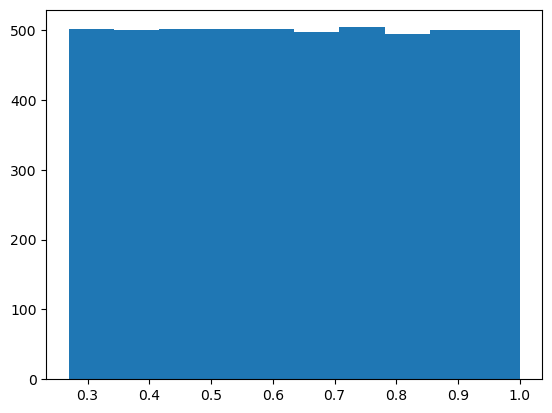

In [31]:
plt.hist(sbp)

(array([501., 500., 501., 501., 501., 497., 504., 495., 500., 500.]),
 array([0.269792  , 0.34280527, 0.4158185 , 0.4888318 , 0.56184506,
        0.6348583 , 0.7078716 , 0.78088486, 0.8538981 , 0.9269114 ,
        0.99992466], dtype=float32),
 <a list of 10 Patch objects>)

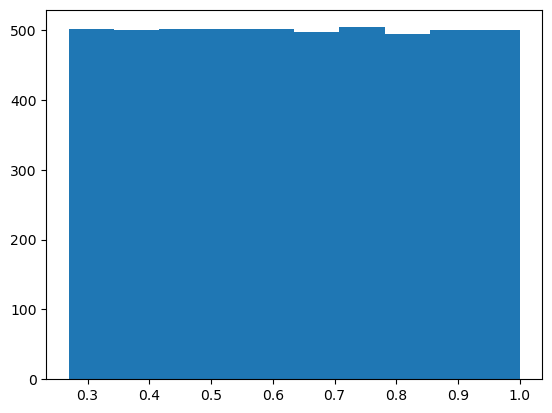

In [218]:
plt.hist(np.max(dataset.data[:30464,:,0].astype(np.float32),axis=-1))

In [48]:
all_img.shape

(5000, 3, 64)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.571726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.089012
[t-SNE] KL divergence after 5000 iterations: 3.354353


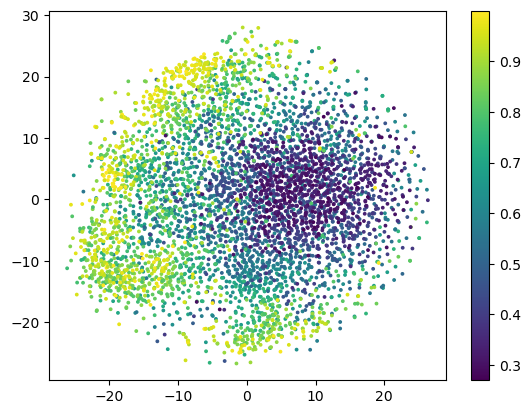

In [51]:
points = TSNE(n_components=2, random_state=0,perplexity=50.0,n_iter=5000,verbose=1).fit_transform(all_img)
cm = plt.cm.get_cmap('viridis')
plt.scatter(points[:,0],points[:,1],s=3,c=sbp,cmap=cm)
plt.colorbar()

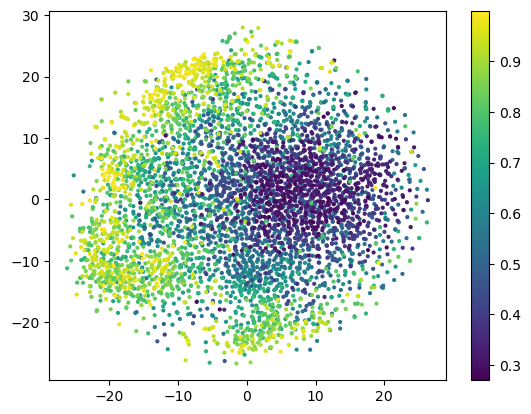

In [52]:
plt.scatter(points[:,0],points[:,1],s=4,c=sbp,cmap=cm)
plt.colorbar()

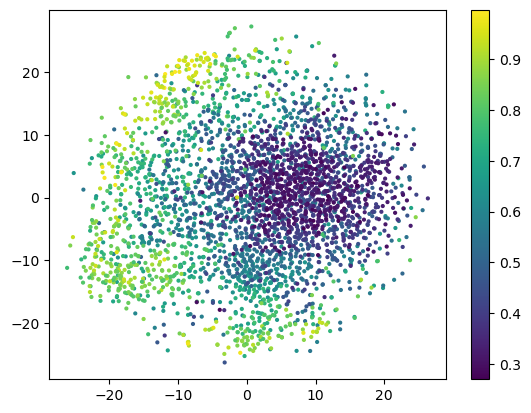

In [54]:
plt.scatter(points[error_0,0],points[error_0,1],s=4,c=sbp[error_0],cmap=cm)
plt.colorbar()

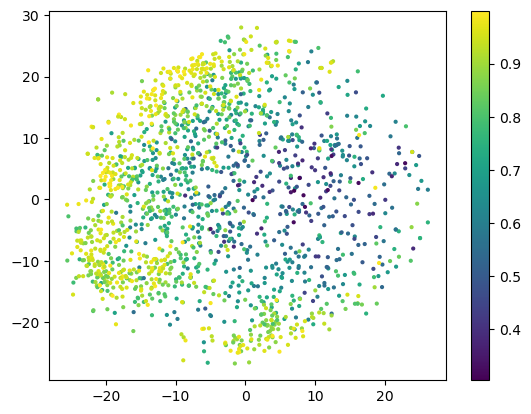

In [55]:
plt.scatter(points[error_1,0],points[error_1,1],s=4,c=sbp[error_1],cmap=cm)
plt.colorbar()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.409s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.499658
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.513344
[t-SNE] KL divergence after 5000 iterations: 3.463475


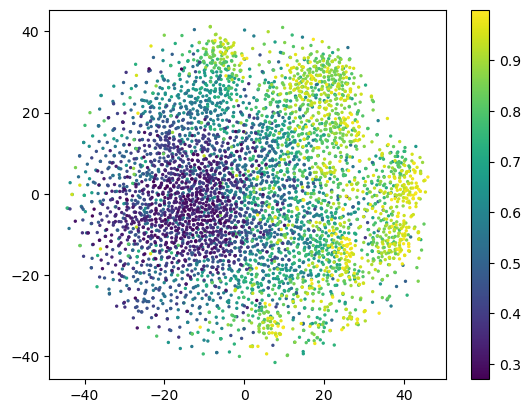

In [225]:
points = TSNE(n_components=2, random_state=0,perplexity=40.0,n_iter=5000,verbose=1).fit_transform(all_img)
cm = plt.cm.get_cmap('viridis')
plt.scatter(points[:,0],points[:,1],s=2,c=sbp,cmap=cm)
plt.colorbar()

In [194]:
points.shape

(30490, 2)

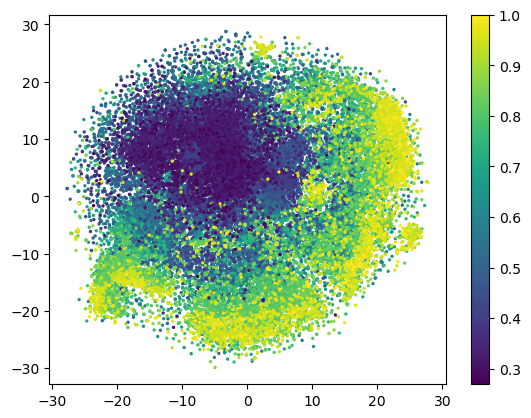

In [202]:
cm = plt.cm.get_cmap('viridis')
plt.scatter(points[:,0],points[:,1],s=2,c=sbp,cmap=cm)
plt.colorbar()

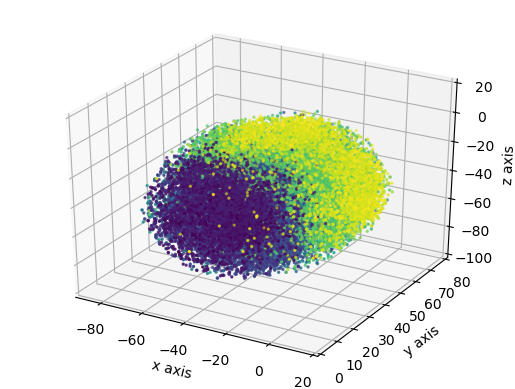

In [200]:
# %matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points3[:,0],points3[:,1],points3[:,2],s=2,c=sbp,cmap=cm)
ax.set_ylim(0,80)
ax.set_xlim(-90,20)
ax.set_zlim(-100,20)
ax.set_xlabel("x axis")
ax.set_ylabel("y axis")
ax.set_zlabel("z axis")
plt.show()

In [56]:
def error_report(errors):
    n_samples = errors.shape[1]
    print("n_samples:",n_samples)
    me = np.mean(errors,axis=1)
    mae = np.mean(np.abs(errors),axis=1)
    rmse = np.sqrt(np.mean(errors**2,axis=1))
    std = np.std(errors,axis=1)
    print(me.shape,mae.shape,rmse.shape,std.shape)
    error_5 = np.count_nonzero(np.abs(errors)<=5,axis=1)/n_samples*100
    error_15 = np.count_nonzero(np.abs(errors)<=15,axis=1)/n_samples*100
    error_10 = np.count_nonzero(np.abs(errors)<=10,axis=1)/n_samples*100
    print("""
        test data samples:
        # samples : {}
        
        Eval Stats:   DBP    SBP
        MAE:        {:6.3f} {:6.3f}
        RMSE:       {:6.3f} {:6.3f}
        Mean Error: {:6.3f} {:6.3f}
        STD:        {:6.3f} {:6.3f}
        
        BHS standards range:
        Error   <5mmHg <10mmHg <15mmHg
        gradeA     60%     85%     95%
        gradeB     50%     75%     90%
        gradeC     40%     65%     85%
        DBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
        SBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
        
        
        """.format(
        n_samples,
        *mae,
        *rmse,
        *me,
        *std,
        error_5[0], error_10[0], error_15[0],
        error_5[1], error_10[1], error_15[1],
        ))

In [57]:
error_report(errors)

n_samples: 5000
(2,) (2,) (2,) (2,)

        test data samples:
        # samples : 5000
        
        Eval Stats:   DBP    SBP
        MAE:         2.963  6.500
        RMSE:        4.029  8.812
        Mean Error: -1.134  2.452
        STD:         3.866  8.464
        
        BHS standards range:
        Error   <5mmHg <10mmHg <15mmHg
        gradeA     60%     85%     95%
        gradeB     50%     75%     90%
        gradeC     40%     65%     85%
        DBP      82.6%   97.9%   99.6%
        SBP      51.0%   79.0%   91.3%
        
        
        
